## 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.svm import OneClassSVM
import hdbscan
from sklearn.cluster import OPTICS
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score

In [2]:
data = pd.read_csv("../data/InjectionMolding_Raw_Data.csv")
data.head()

No_Shot  Machine_Cycle_Time  Cycle_Time  Barrel_Temp_Z1  Barrel_Temp_Z2  \
0        0               16.54       16.52           210.2           200.7   
1        1               16.56       16.54           210.2           200.8   
2        2               16.58       16.56           210.1           200.7   
3        3               16.62       16.58           210.1           200.6   
4        4               16.62       16.62           210.0           200.5   

   Barrel_Temp_Z3  Barrel_Temp_Z4  Hopper_Temp  Injection_Pressure_Real_Time  \
0           193.5           187.3         40.1                          1.23   
1           193.5           187.2         40.2                          1.24   
2           193.5           187.2         40.2                          1.26   
3           193.5           187.2         40.2                          1.30   
4           193.4           187.3         40.1                          1.31   

   Screw_Position  ...  VP_Press  Plasticizing_Time  \
0            6.02  ...   1062.00               4.74   
1            6.02  ...   1062.00               4.81   
2            6.02  ...   1101.41               4.80   
3            6.28  ...   1092.55               4.84   
4            6.46  ...   1153.41               4.86   

   Plasticizing_Start_Position  Plasticizing_End_Position  Plasticizing_RPM  \
0                        10.46                      63.11             28.27   
1                        10.49                      63.11             28.27   
2                        10.53                      63.11             28.27   
3                        10.78                      63.11             28.27   
4                        10.94                      63.11             28.27   

   Minimum_Cushion  Cooling_Time  Back_Flow  Decompression_Time  _ID  
0             6.02           8.0      49.03                0.32    0  
1             6.02           8.0      49.03                0.32    1  
2             6.02           8.0      49.03                0.32    2  
3             6.28           8.0      49.03                0.33    3  
4             6.46           8.0      49.03                0.33    4  

[5 rows x 26 columns]

## 정보확인

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030635 entries, 0 to 1030634
Data columns (total 26 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   No_Shot                       1030635 non-null  int64  
 1   Machine_Cycle_Time            1030635 non-null  float64
 2   Cycle_Time                    1030635 non-null  float64
 3   Barrel_Temp_Z1                1030635 non-null  float64
 4   Barrel_Temp_Z2                1030635 non-null  float64
 5   Barrel_Temp_Z3                1030635 non-null  float64
 6   Barrel_Temp_Z4                1030635 non-null  float64
 7   Hopper_Temp                   1030635 non-null  float64
 8   Injection_Pressure_Real_Time  1030635 non-null  float64
 9   Screw_Position                1030635 non-null  float64
 10  Injection_Peak_Press          1030635 non-null  float64
 11  Max_Injection_Rate            1030635 non-null  float64
 12  Screw_Velocity              

In [4]:
columns = data.columns
columns

Index(['No_Shot', 'Machine_Cycle_Time', 'Cycle_Time', 'Barrel_Temp_Z1',
       'Barrel_Temp_Z2', 'Barrel_Temp_Z3', 'Barrel_Temp_Z4', 'Hopper_Temp',
       'Injection_Pressure_Real_Time', 'Screw_Position',
       'Injection_Peak_Press', 'Max_Injection_Rate', 'Screw_Velocity',
       'VP_Time', 'VP_Position', 'Weighing_Start_Position', 'VP_Press',
       'Plasticizing_Time', 'Plasticizing_Start_Position',
       'Plasticizing_End_Position', 'Plasticizing_RPM', 'Minimum_Cushion',
       'Cooling_Time', 'Back_Flow', 'Decompression_Time', '_ID'],
      dtype='object')

### 결측치 처리

In [5]:
data[data.isnull() == True].count().sum()

0

In [6]:
data_drop=data.copy().drop(['Minimum_Cushion','Weighing_Start_Position','_ID'],axis=1)

###  Lot 단위 데이터 정리
Lot : 1회에 생산되는 특정수의 제품단위

In [7]:
def to_lot(data):

    lot_list = [0,data.shape[0]]

    for i in range(data.shape[0]):
        if data['No_Shot'][i] == 0:
            lot_list.append(i)

    lot_list.sort()

    data_lot = []

    for i in range(len(lot_list)-1):
        data_lot.append(data.iloc[lot_list[i]:lot_list[i+1]])

    return data_lot

In [8]:
data_lot=to_lot(data_drop)
data_lot

[Empty DataFrame
 Columns: [No_Shot, Machine_Cycle_Time, Cycle_Time, Barrel_Temp_Z1, Barrel_Temp_Z2, Barrel_Temp_Z3, Barrel_Temp_Z4, Hopper_Temp, Injection_Pressure_Real_Time, Screw_Position, Injection_Peak_Press, Max_Injection_Rate, Screw_Velocity, VP_Time, VP_Position, VP_Press, Plasticizing_Time, Plasticizing_Start_Position, Plasticizing_End_Position, Plasticizing_RPM, Cooling_Time, Back_Flow, Decompression_Time]
 Index: []
 
 [0 rows x 23 columns],
      No_Shot  Machine_Cycle_Time  Cycle_Time  Barrel_Temp_Z1  Barrel_Temp_Z2  \
 0          0               16.54       16.52           210.2           200.7   
 1          1               16.56       16.54           210.2           200.8   
 2          2               16.58       16.56           210.1           200.7   
 3          3               16.62       16.58           210.1           200.6   
 4          4               16.62       16.62           210.0           200.5   
 ..       ...                 ...         ...            

'No_Shot’ 번호를 기준으로 Lot을 분리

In [10]:
def error_drop(data_lot):
    normal_lot = []
    for i in range(len(data_lot)):
        if data_lot[i].shape[0] >= 100:
            normal_lot.append(data_lot[i])
    return normal_lot


In [11]:
# Shot의 갯수가 100개 미만인 Lot을 이상치라 판단, 제거
data_n_lot=error_drop(data_lot)

### 데이터 시각화

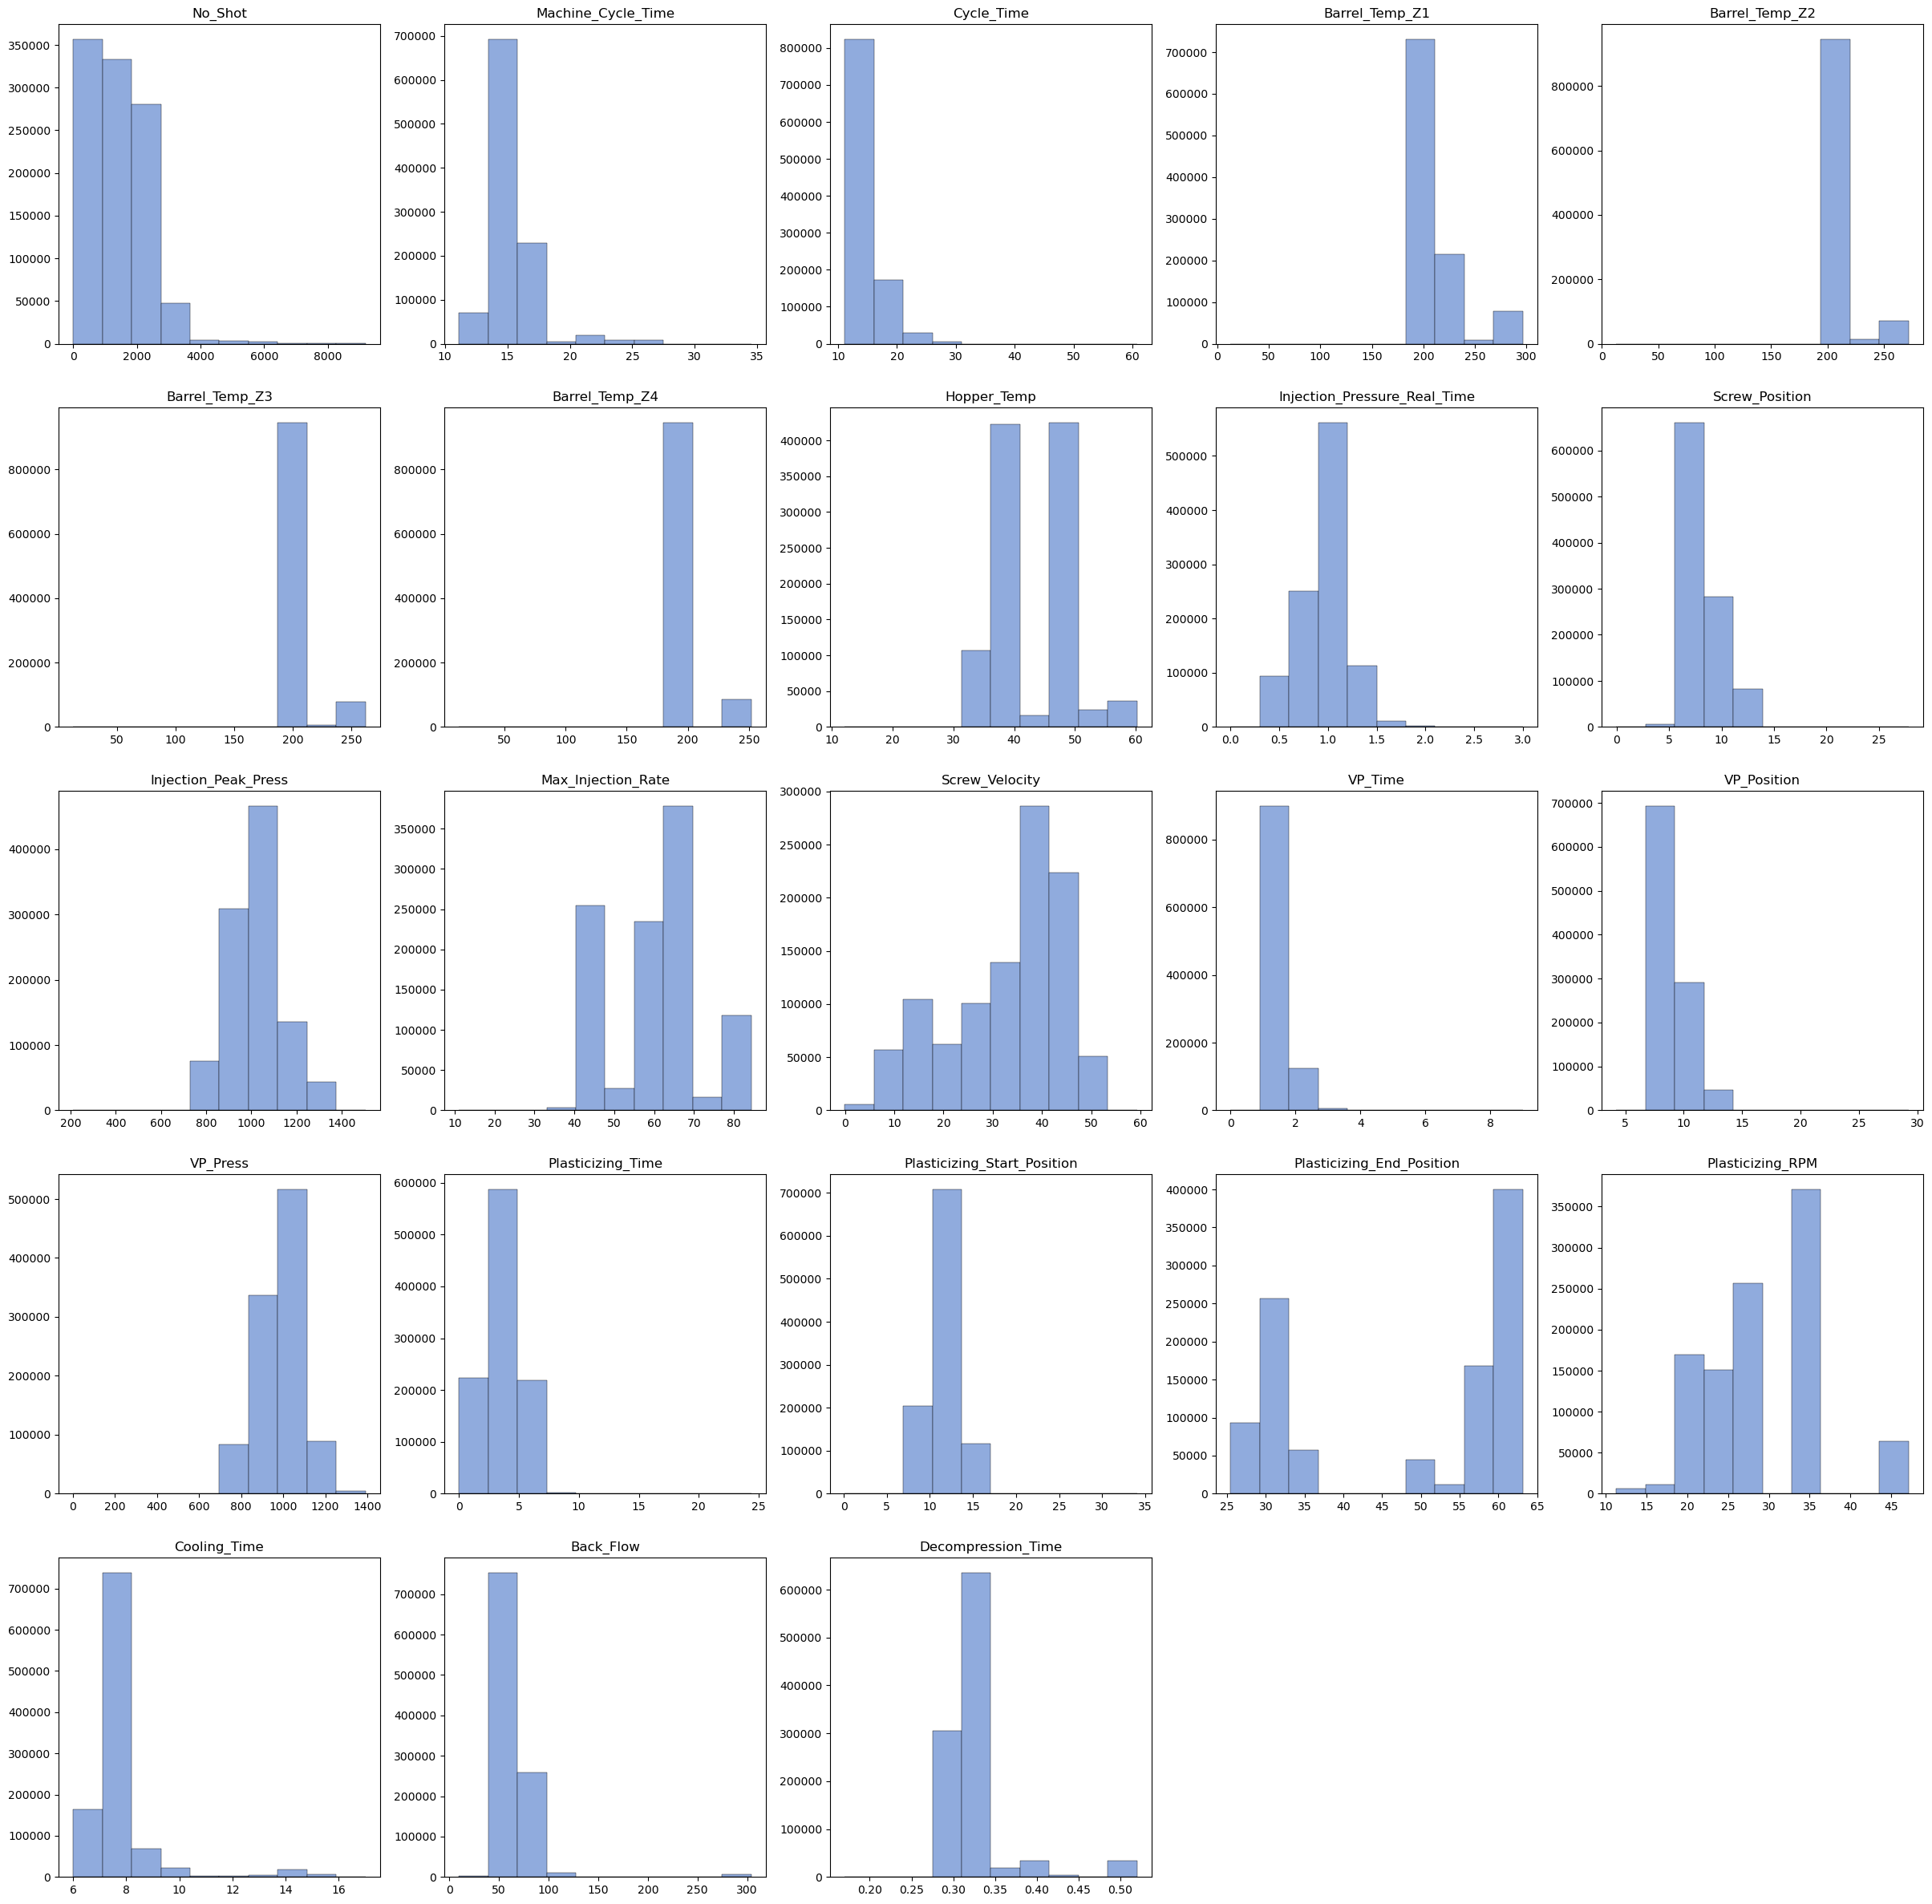

In [12]:
plt.figure(figsize=(30,30))
for index, value in enumerate(data_drop):
    sub = plt.subplot(5,5,index+1)
    sub.hist(data_drop[value], facecolor = (144/255,171/255,221/255), linewidth=.3, edgecolor='black')
    plt.title(value)

### 상관계수 시각화

<Axes: >

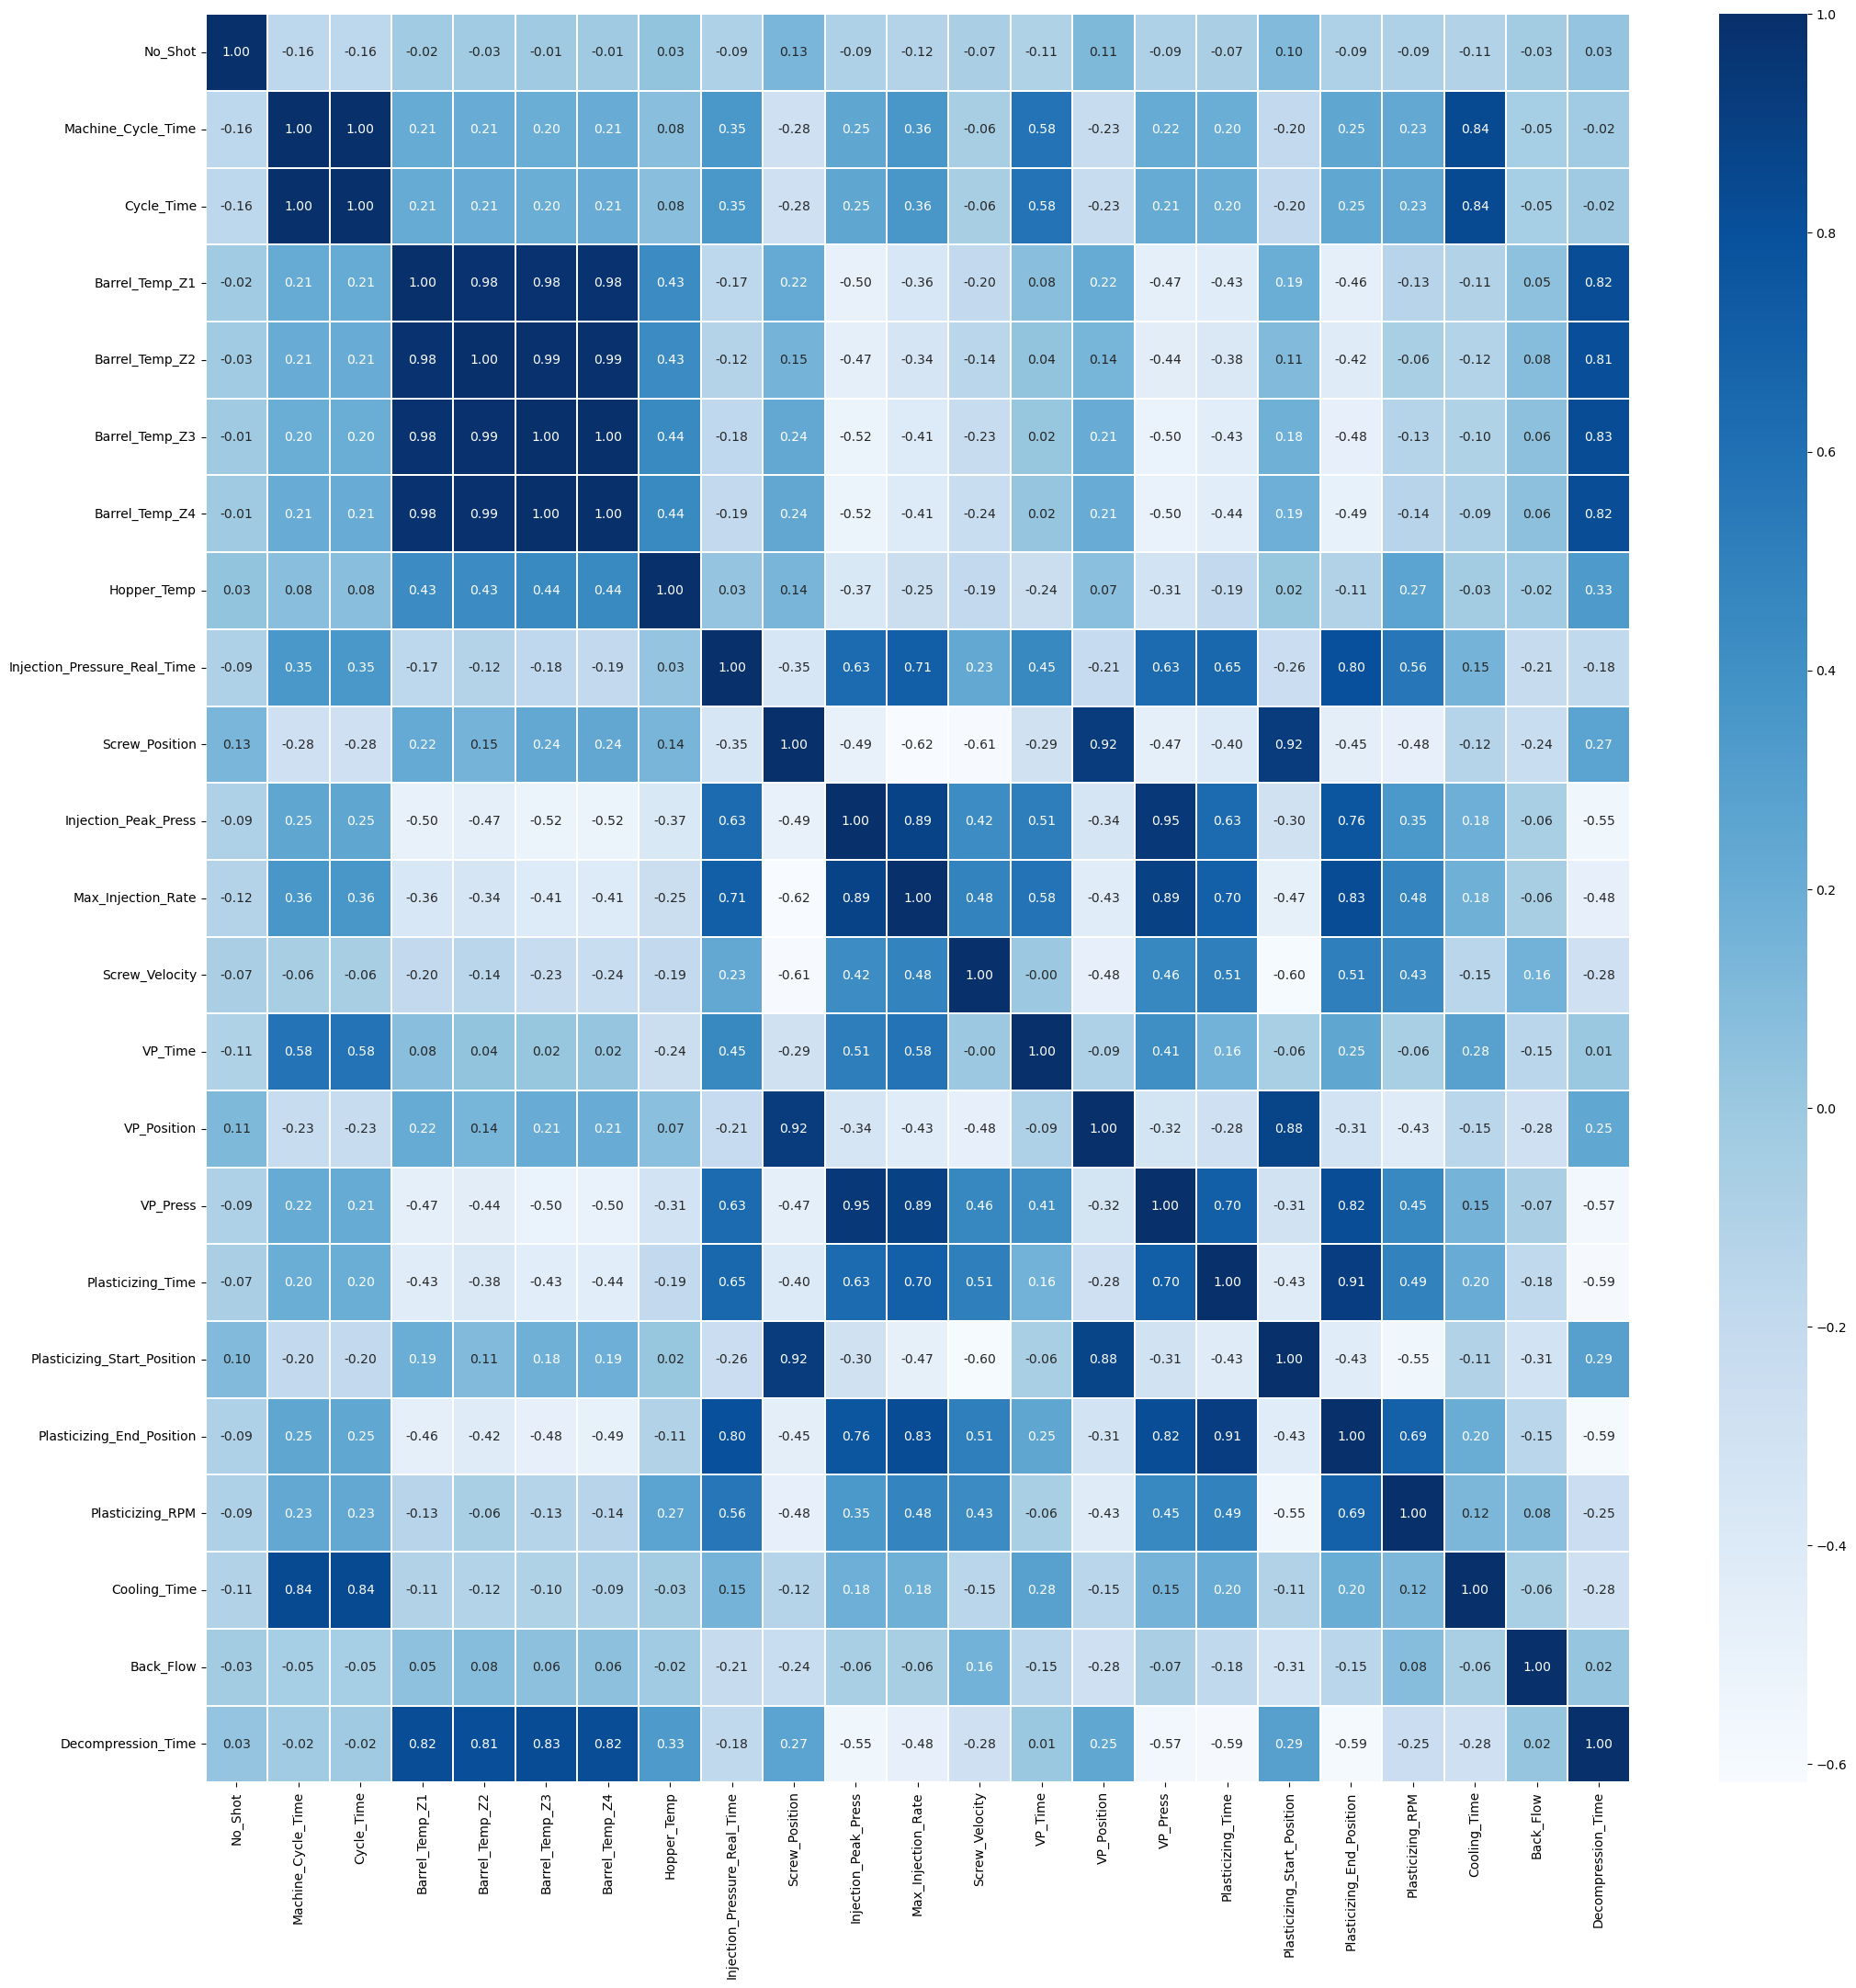

In [13]:
plt.subplots(figsize=(25,25))
sns.heatmap(data = data_drop.corr(), linewidths=0.1, annot=True, fmt='.2f', cmap='Blues')

## 학습/평가 데이터 준비

### mean값 데이터 프레임

In [14]:
data_list = []
for i in range(len(data_n_lot)):
    data_list.append(data_n_lot[i].mean())

lot_mean = pd.DataFrame(data_list).drop(['No_Shot'], axis=1)

In [15]:
lot_mean.head()

Machine_Cycle_Time  Cycle_Time  Barrel_Temp_Z1  Barrel_Temp_Z2  \
0           16.668679   16.681723      209.998316      200.042358   
1           16.660866   16.677780      209.999803      200.038804   
2           16.681288   16.699753      209.996035      200.036514   
3           16.634533   16.653553      209.998039      200.040196   
4           16.610939   16.624291      209.996946      200.031504   

   Barrel_Temp_Z3  Barrel_Temp_Z4  Hopper_Temp  Injection_Pressure_Real_Time  \
0      194.962824      189.962435    40.085622                      1.367863   
1      195.007241      190.018890    40.089532                      1.363695   
2      195.001296      190.016765    40.078406                      1.382933   
3      195.001059      190.008471    40.090627                      1.338847   
4      195.009702      190.020371    40.125474                      1.308349   

   Screw_Position  Injection_Peak_Press  ...  VP_Time  VP_Position  \
0        6.535635           1259.353666  ...      2.0     8.119780   
1        6.509563           1270.757599  ...      2.0     8.119437   
2        6.640133           1252.482285  ...      2.0     8.121991   
3        6.524275           1244.939608  ...      2.0     8.123667   
4        6.465195           1239.340870  ...      2.0     8.124291   

      VP_Press  Plasticizing_Time  Plasticizing_Start_Position  \
0  1184.873031           4.797461                    11.008510   
1  1161.965710           4.789536                    11.000386   
2  1184.553149           4.684229                    11.087640   
3  1113.798486           4.731149                    11.006322   
4  1109.827781           4.630274                    10.976884   

   Plasticizing_End_Position  Plasticizing_RPM  Cooling_Time  Back_Flow  \
0                  63.111632             28.27           8.0      49.03   
1                  63.111625             28.27           8.0      49.03   
2                  63.111457             28.27           8.0      49.03   
3                  63.111573             28.27           8.0      49.03   
4                  63.111736             28.27           8.0      49.03   

   Decompression_Time  
0            0.322306  
1            0.321893  
2            0.321735  
3            0.321718  
4            0.321701  

[5 rows x 22 columns]

### 중앙값 데이터 프레임

In [16]:
# Lot별 대표값 데이터프레임
# 대표값은 중앙값으로
data_list = []
for I in range(len(data_n_lot)):
    data_list.append(data_n_lot[i].median())

lot_median = pd.DataFrame(data_list).drop(['No_Shot'], axis=1)

In [17]:
lot_median.head()

Machine_Cycle_Time  Cycle_Time  Barrel_Temp_Z1  Barrel_Temp_Z2  \
0                15.1       15.12           290.0           270.0   
1                15.1       15.12           290.0           270.0   
2                15.1       15.12           290.0           270.0   
3                15.1       15.12           290.0           270.0   
4                15.1       15.12           290.0           270.0   

   Barrel_Temp_Z3  Barrel_Temp_Z4  Hopper_Temp  Injection_Pressure_Real_Time  \
0           260.0           250.0         55.8                          0.81   
1           260.0           250.0         55.8                          0.81   
2           260.0           250.0         55.8                          0.81   
3           260.0           250.0         55.8                          0.81   
4           260.0           250.0         55.8                          0.81   

   Screw_Position  Injection_Peak_Press  ...  VP_Time  VP_Position  VP_Press  \
0            9.23                776.95  ...      1.0        10.16    776.45   
1            9.23                776.95  ...      1.0        10.16    776.45   
2            9.23                776.95  ...      1.0        10.16    776.45   
3            9.23                776.95  ...      1.0        10.16    776.45   
4            9.23                776.95  ...      1.0        10.16    776.45   

   Plasticizing_Time  Plasticizing_Start_Position  Plasticizing_End_Position  \
0               2.07                        11.68                      26.47   
1               2.07                        11.68                      26.47   
2               2.07                        11.68                      26.47   
3               2.07                        11.68                      26.47   
4               2.07                        11.68                      26.47   

   Plasticizing_RPM  Cooling_Time  Back_Flow  Decompression_Time  
0             28.27           6.5      49.03                 0.4  
1             28.27           6.5      49.03                 0.4  
2             28.27           6.5      49.03                 0.4  
3             28.27           6.5      49.03                 0.4  
4             28.27           6.5      49.03                 0.4  

[5 rows x 22 columns]

### 3분위수 데이터 프레임

In [18]:
# Lot별 대표값 데이터프레임
# 대표값은 3분위수로
data_list = []
for i in range(len(data_n_lot)):
    data_list.append(data_n_lot[i].quantile(.75))

lot_75 = pd.DataFrame(data_list).drop(['No_Shot'], axis=1).reset_index(drop=True)

In [19]:
lot_75.head()

Machine_Cycle_Time  Cycle_Time  Barrel_Temp_Z1  Barrel_Temp_Z2  \
0               16.68       16.70           210.0           200.1   
1               16.68       16.70           210.0           200.1   
2               16.70       16.72           210.0           200.1   
3               16.66       16.66           210.0           200.1   
4               16.62       16.64           210.0           200.1   

   Barrel_Temp_Z3  Barrel_Temp_Z4  Hopper_Temp  Injection_Pressure_Real_Time  \
0           195.1           190.1         40.2                          1.39   
1           195.1           190.1         40.2                          1.38   
2           195.1           190.1         40.2                          1.40   
3           195.1           190.1         40.2                          1.35   
4           195.1           190.1         40.2                          1.31   

   Screw_Position  Injection_Peak_Press  ...  VP_Time  VP_Position  VP_Press  \
0            6.58             1272.2925  ...      2.0         8.13   1201.43   
1            6.56             1284.7400  ...      2.0         8.13   1178.11   
2            6.71             1263.9100  ...      2.0         8.13   1223.25   
3            6.57             1257.4200  ...      2.0         8.13   1123.48   
4            6.52             1255.4300  ...      2.0         8.13   1125.98   

   Plasticizing_Time  Plasticizing_Start_Position  Plasticizing_End_Position  \
0               4.82                       11.050                      63.11   
1               4.82                       11.050                      63.11   
2               4.77                       11.145                      63.11   
3               4.77                       11.050                      63.11   
4               4.65                       11.030                      63.11   

   Plasticizing_RPM  Cooling_Time  Back_Flow  Decompression_Time  
0             28.27           8.0      49.03                0.32  
1             28.27           8.0      49.03                0.32  
2             28.27           8.0      49.03                0.32  
3             28.27           8.0      49.03                0.32  
4             28.27           8.0      49.03                0.32  

[5 rows x 22 columns]

In [20]:
# Lot별 대표값 데이터프레임
# 대표값은 1분위수로
data_list = []
for i in range(len(data_n_lot)):
    data_list.append(data_n_lot[i].quantile(.25))

lot_25 = pd.DataFrame(data_list).drop(['No_Shot'], axis=1).reset_index(drop=True)

In [21]:
lot_75.head()

Machine_Cycle_Time  Cycle_Time  Barrel_Temp_Z1  Barrel_Temp_Z2  \
0               16.68       16.70           210.0           200.1   
1               16.68       16.70           210.0           200.1   
2               16.70       16.72           210.0           200.1   
3               16.66       16.66           210.0           200.1   
4               16.62       16.64           210.0           200.1   

   Barrel_Temp_Z3  Barrel_Temp_Z4  Hopper_Temp  Injection_Pressure_Real_Time  \
0           195.1           190.1         40.2                          1.39   
1           195.1           190.1         40.2                          1.38   
2           195.1           190.1         40.2                          1.40   
3           195.1           190.1         40.2                          1.35   
4           195.1           190.1         40.2                          1.31   

   Screw_Position  Injection_Peak_Press  ...  VP_Time  VP_Position  VP_Press  \
0            6.58             1272.2925  ...      2.0         8.13   1201.43   
1            6.56             1284.7400  ...      2.0         8.13   1178.11   
2            6.71             1263.9100  ...      2.0         8.13   1223.25   
3            6.57             1257.4200  ...      2.0         8.13   1123.48   
4            6.52             1255.4300  ...      2.0         8.13   1125.98   

   Plasticizing_Time  Plasticizing_Start_Position  Plasticizing_End_Position  \
0               4.82                       11.050                      63.11   
1               4.82                       11.050                      63.11   
2               4.77                       11.145                      63.11   
3               4.77                       11.050                      63.11   
4               4.65                       11.030                      63.11   

   Plasticizing_RPM  Cooling_Time  Back_Flow  Decompression_Time  
0             28.27           8.0      49.03                0.32  
1             28.27           8.0      49.03                0.32  
2             28.27           8.0      49.03                0.32  
3             28.27           8.0      49.03                0.32  
4             28.27           8.0      49.03                0.32  

[5 rows x 22 columns]

### IQR 기반 abnormal 데이터 정의

In [22]:
# IQR을 통한 이상치 분류 함수
def outliers_iqr(data):
    q1, q3 = np.percentile(data,[25,75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr*1.5)
    upper_bound = q3 + (iqr*1.5)

    return np.where((data>upper_bound)|(data<lower_bound))

In [23]:
# Lot별 대표값을 통한 abnormal 탐색 함수
# 각 컬럼별 이상치가 4개 이상인 Lot 번호(index)를 abnormal이라 판단

def outlier_search(lot_rep):
    rep_index = []
    
    for i in range(lot_rep.shape[1]):
        rep_index.append(outliers_iqr(lot_rep[lot_rep.columns[i]])[0])

    a = 0
    outlier_index = []

    for i in range(len(lot_rep)):
        a = 0
        for j in rep_index:
            if i in j:
                a = a + 1
        if a > 3:
            outlier_index.append(i)

    return outlier_index


In [24]:
# 각 대표값 별 abnormal 합집합
IQR_error=sorted((list(set(outlier_search(lot_mean)+outlier_search(lot_median) + outlier_search(lot_75)+outlier_search(lot_25)))))
print(IQR_error)

[85, 86, 87, 88, 89, 90, 91, 92, 93, 97, 100, 101, 102, 103, 113, 114, 325, 328, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380]


### DBSCAN 기반 abnormal 데이터 정의
밀도 기반의 군집화 알고리즘으로, 데이터의 밀도가 높은 부분을 군집으로 구분하고 밀도가 낮은 부분을 이상치로 간주

In [25]:
# x: 독립변인들의value값만추출
# y: 종속변인추출
x = lot_mean.drop(['Machine_Cycle_Time'], axis=1).values
y = lot_mean['Machine_Cycle_Time'].values

In [26]:
# scaler
x = MinMaxScaler().fit_transform(x)

#### PCA

In [27]:
# 2개의 주성분(n_components)으로 이루어진 데이터프레임 구성
pca = PCA(n_components=2)
printcipalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
principalDf.head()

principal component1  principal component2
0             -0.873603              0.343205
1             -0.865574              0.340311
2             -0.837708              0.320043
3             -0.785490              0.296093
4             -0.766725              0.286019

In [28]:
# epsilon, 최소 샘플 개수 설정
# 모델을 DBSCAN 알고리즘 사용
a = 0.165
b = 10
model = DBSCAN(eps=a, min_samples=b)

In [29]:
# 군집화 모델 학습 및 클러스터 예측 결과 반환
model.fit(principalDf)
principalDf['cluster'] = model.fit_predict(principalDf)

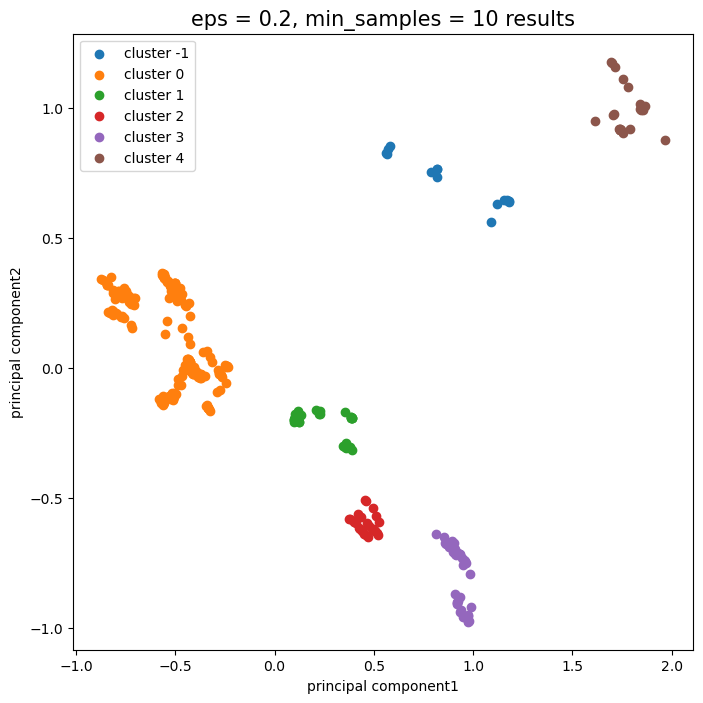

In [30]:
# matplotlib 라이브러리를 통한 군집 시각화
# 이상치 번호는 -1, 클러스터 최대 숫자까지 iteration
plt.figure(figsize=(8,8))
for i in range(-1, principalDf['cluster'].max() + 1):
    plt.scatter(principalDf.loc[principalDf['cluster'] == i, 'principal component1'],
    principalDf.loc[principalDf['cluster'] == i, 'principal component2'], label = 'cluster ' + str(i))
plt.legend()
plt.title('eps = %.1f, min_samples = %d results'%(a, b), size=15)
plt.xlabel('principal component1', size=10)
plt.ylabel('principal component2', size=10)
plt.show()

In [31]:
# DBSCAN 군집화를 통해 발견한 abnormal 예상 Lot 분류
DB_error=[]
for I in range(len(principalDf)):

    if principalDf['cluster'][i]==4:
        DB_error.append(i)
    elif principalDf['cluster'][i]==-1:
        DB_error.append(i)

### HDBSCAN
DBSCAN의 계층적 버전으로, 다양한 밀도의 군집을 탐지할 수 있는 능력을 갖추고 있습니다. HDBSCAN은 군집의 밀도 차이가 큰 데이터셋에 적합하며, 군집의 계층 구조를 제공

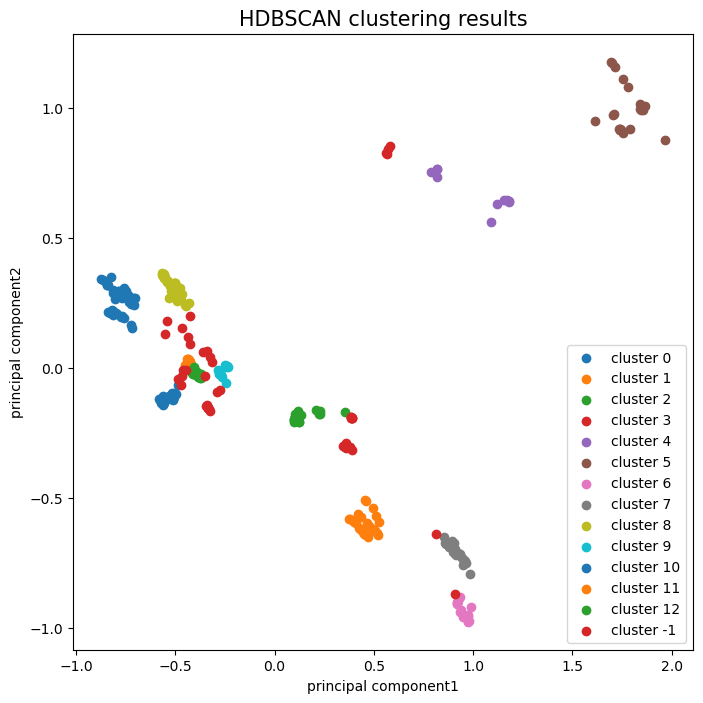

In [32]:
# x와 y 데이터 준비
x = lot_mean.drop(['Machine_Cycle_Time'], axis=1).values
y = lot_mean['Machine_Cycle_Time'].values

# MinMaxScaler를 통한 데이터 스케일링
x = MinMaxScaler().fit_transform(x)

# PCA를 통한 차원 축소
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component1', 'principal component2'])

# HDBSCAN 모델 생성 및 학습
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=10)

principalDf['cluster'] = hdbscan_model.fit_predict(principalDf)

# matplotlib 라이브러리를 통한 군집 시각화
plt.figure(figsize=(8,8))
# 이상치 번호는 -1, 클러스터 최대 숫자까지 iteration
unique_clusters = set(principalDf['cluster'])
for cluster in unique_clusters:
    plt.scatter(principalDf.loc[principalDf['cluster'] == cluster, 'principal component1'],
                principalDf.loc[principalDf['cluster'] == cluster, 'principal component2'], label='cluster ' + str(cluster))
plt.legend()
plt.title('HDBSCAN clustering results', size=15)
plt.xlabel('principal component1', size=10)
plt.ylabel('principal component2', size=10)
plt.show()

# HDBSCAN 군집화를 통해 발견한 abnormal 예상 Lot 분류
HDB_error = []
for i in range(len(principalDf)):
    if principalDf['cluster'][i] == -1:
        HDB_error.append(i)


### OPTICS (Ordering Points To Identify the Clustering Structure)
OPTICS는 DBSCAN과 매우 유사한 알고리즘입니다. DBSCAN과 달리, OPTICS는 군집의 밀도가 서로 다를 때 더 잘 작동

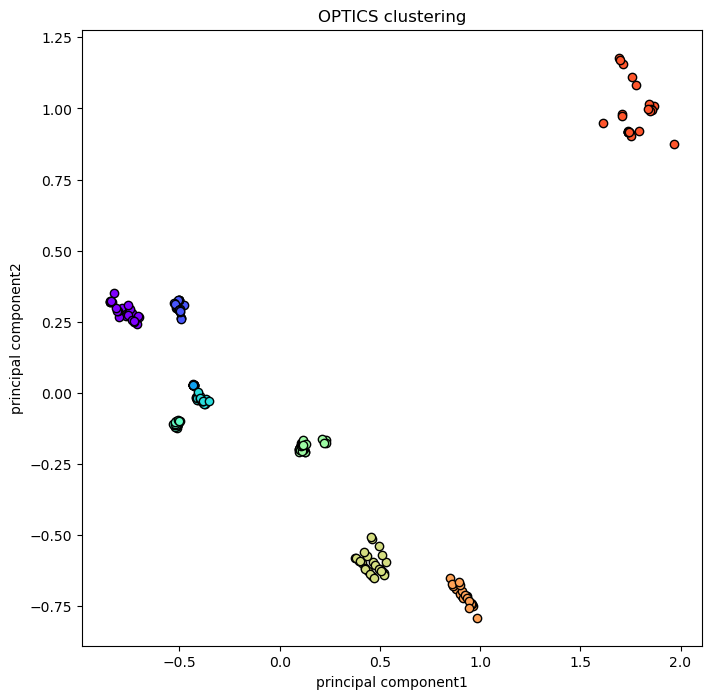

In [33]:
# 독립변인과 종속변인 준비
x = lot_mean.drop(['Machine_Cycle_Time'], axis=1).values
y = lot_mean['Machine_Cycle_Time'].values

# 데이터 스케일링
x = MinMaxScaler().fit_transform(x)

# PCA를 통한 차원 축소
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component1', 'principal component2'])

# OPTICS 모델 생성 및 학습
optics_model = OPTICS(min_samples=10, cluster_method='xi', xi=0.05, min_cluster_size=0.05)

# 군집화 모델 학습 및 클러스터 예측 결과 반환
principalDf['cluster'] = optics_model.fit_predict(principalDf)

# 군집 시각화
plt.figure(figsize=(8,8))
colors = plt.cm.rainbow(np.linspace(0, 1, len(set(optics_model.labels_))))
for klass, color in zip(range(0, len(set(optics_model.labels_))), colors):
    Xk = principalDf.loc[optics_model.labels_ == klass]
    plt.plot(Xk.iloc[:, 0], Xk.iloc[:, 1], 'o', markerfacecolor=color, markeredgecolor='k', markersize=6)
plt.title('OPTICS clustering')
plt.xlabel('principal component1')
plt.ylabel('principal component2')
plt.show()

# 이상치 탐지
OPTICS_error = []
for i in range(len(principalDf)):
    if principalDf['cluster'][i] == -1: # -1은 이상치를 의미
        OPTICS_error.append(i)


### 최종 labeling

In [34]:
# IQR을 통한 abnormal Lot 번호와 DBSCAN을 통한 abnormal Lot 번호의 합집합
# 총 43개의 Lot을 abnormal이라 판단
error_list = sorted(list(set(IQR_error + DB_error)))
print('abnormal Lot 번호:', error_list)
print('abnormal Lot 개수:', len(error_list))

abnormal Lot 번호: [85, 86, 87, 88, 89, 90, 91, 92, 93, 97, 100, 101, 102, 103, 113, 114, 325, 328, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380]
abnormal Lot 개수: 43


In [35]:
# Shot 데이터에 Lot 번호 라벨링
n_Lot_list = []
for i in range(len(data_n_lot)):
    a = i
    Lot_label = data_n_lot[i].copy()
    Lot_label.loc[:,['Lot']] = a
    n_Lot_list.append(Lot_label)

In [36]:
# concat 함수를 통한 데이터 결합
data_lot_label = n_Lot_list[0]
for i in range(len(n_Lot_list)):
    if i ==  0:
        pass
    else:
        data_lot_label = pd.concat([data_lot_label, n_Lot_list[i]])

data_lot_label = data_lot_label.reset_index(drop=True)

In [37]:
# abnormal shot 라벨링
data_lot_label.loc[:, ['PassOrFail']] = 0
for i in range(len(data_lot_label)):
    if data_lot_label['Lot'][i] in error_list:
        data_lot_label.loc[i,['PassOrFail']]=1

data_shot_label = data_lot_label.copy().drop(['No_Shot'],axis=1)

In [38]:
# 라벨링 갯수 비교
data_shot_label['PassOrFail'].value_counts()

PassOrFail
0    935814
1     94600
Name: count, dtype: int64

In [39]:
# 사용했던 Lot칼럼 삭제
data_shot_label = data_shot_label.copy().drop(['Lot'],axis=1)
data_shot_label

Machine_Cycle_Time  Cycle_Time  Barrel_Temp_Z1  Barrel_Temp_Z2  \
0                     16.54       16.52           210.2           200.7   
1                     16.56       16.54           210.2           200.8   
2                     16.58       16.56           210.1           200.7   
3                     16.62       16.58           210.1           200.6   
4                     16.62       16.62           210.0           200.5   
...                     ...         ...             ...             ...   
1030409               15.12       15.12           290.0           270.0   
1030410               15.10       15.14           290.0           269.9   
1030411               15.10       15.12           290.0           270.0   
1030412               15.10       15.10           290.0           270.0   
1030413               15.10       15.12           290.0           270.0   

         Barrel_Temp_Z3  Barrel_Temp_Z4  Hopper_Temp  \
0                 193.5           187.3         40.1   
1                 193.5           187.2         40.2   
2                 193.5           187.2         40.2   
3                 193.5           187.2         40.2   
4                 193.4           187.3         40.1   
...                 ...             ...          ...   
1030409           260.0           250.0         51.8   
1030410           260.0           250.0         52.0   
1030411           260.0           250.0         52.2   
1030412           259.9           249.9         52.4   
1030413           260.0           250.0         52.6   

         Injection_Pressure_Real_Time  Screw_Position  Injection_Peak_Press  \
0                                1.23            6.02               1211.65   
1                                1.24            6.02               1211.65   
2                                1.26            6.02               1209.16   
3                                1.30            6.28               1228.24   
4                                1.31            6.46               1287.11   
...                               ...             ...                   ...   
1030409                          0.82            9.29                778.07   
1030410                          0.80            9.29                777.58   
1030411                          0.80            9.23                777.20   
1030412                          0.81            9.24                777.83   
1030413                          0.80            9.19                776.83   

         ...  VP_Position  VP_Press  Plasticizing_Time  \
0        ...         8.14   1062.00               4.74   
1        ...         8.14   1062.00               4.81   
2        ...         8.12   1101.41               4.80   
3        ...         8.12   1092.55               4.84   
4        ...         8.10   1153.41               4.86   
...      ...          ...       ...                ...   
1030409  ...        10.16    777.45               2.05   
1030410  ...        10.16    777.08               2.04   
1030411  ...        10.18    776.70               2.05   
1030412  ...        10.16    777.58               2.02   
1030413  ...        10.17    776.45               2.03   

         Plasticizing_Start_Position  Plasticizing_End_Position  \
0                              10.46                      63.11   
1                              10.49                      63.11   
2                              10.53                      63.11   
3                              10.78                      63.11   
4                              10.94                      63.11   
...                              ...                        ...   
1030409                        11.72                      26.47   
1030410                        11.74                      26.46   
1030411                        11.66                      26.47   
1030412                        11.67                      26.47   
1030413                        11.65                

### 2차 전처리

In [ ]:
# data_shot_label = data

In [40]:
# Lot별 평균 데이터 스케일링
scaler = MinMaxScaler()
df_sum_drop_scaler = scaler.fit_transform(data_shot_label)
df_sum_drop_scaler = pd.DataFrame(df_sum_drop_scaler)

### 데이터 분리

In [41]:
# normal shot
df_Y_scaler = df_sum_drop_scaler[df_sum_drop_scaler[-1]==0]
print('normal shot:', len(df_Y_scaler))

# abnormal shot
df_N_scaler = df_sum_drop_scaler[df_sum_drop_scaler[-1]==1]
print('abnormal shot:', len(df_N_scaler))

normal shot: 935814
abnormal shot: 94600


In [42]:
# 'PassOrFail’ 변수 제거 -> 학습을 위해 클래스 변수 없애기
df_Y_scaler = df_Y_scaler.drop(columns=[22])
df_N_scaler = df_N_scaler.drop(columns=[22])

In [43]:
# 학습 데이터, 평가데이터(normal shot)
Y_train, Y_test = train_test_split(df_Y_scaler, test_size = 0.3, random_state = 34)

# 평가 데이터(abnromal shot)
N_test = df_N_scaler

print('normal 학습 데이터셋 개수:', len(Y_train))
print('normal 평가 데이터셋 개수:', len(Y_test))
print('abnormal 평가 데이터셋 개수:', len(N_test))

normal 학습 데이터셋 개수: 655069
normal 평가 데이터셋 개수: 280745
abnormal 평가 데이터셋 개수: 94600


## 모델 구축

In [44]:
# 인코더
dropout_encoder = Sequential([
 Dropout(0.3),
 Dense(15, activation="relu"),# 첫 번째 은닉층
 Dense(5, activation="relu")# 두 번째 은닉층
])
# 디코더
dropout_decoder = Sequential([
 Dense(15, activation="relu", input_shape=[5]),# 세 번째 은닉층
 Dense(Y_train.shape[1], activation='relu'),# 출력
])
dropout_AE = Sequential([dropout_encoder, dropout_decoder])

C:\Users\82109\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 모델 훈련

In [ ]:
# 손실함수 옵티마이저 정의
dropout_AE.compile(loss="mse", optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
# 모델 훈련(EarlyStopping)
history = dropout_AE.fit(Y_train, Y_train, batch_size=30, epochs=30, validation_split=0.2,
 callbacks=[EarlyStopping(monitor="val_loss", patience=7, mode="min")])

## 결과 분석

In [ ]:
# 학습 데이터의 예측값
train_pred = dropout_AE.predict(Y_train)
# 학습 데이터의 복원 오차 (예측값 ­ 실제 값)
train_loss = np.mean(np.square(train_pred-Y_train),axis=1)
# 임계치
threshold = np.mean(train_loss) + 5*np.std(train_loss)
print("복원 오류 임계치:", threshold)

In [ ]:
# 예측값
predict_Y = dropout_AE.predict(Y_test)
# normal 평가 데이터의 복원 오차 (예측값 ­ 실제 값)
test_Y_mse = np.mean(np.square(predict_Y - Y_test),axis=1)
# normal로 판단한 데이터 확인
test_Y_anomalies = test_Y_mse > threshold
print("normal로 판단한 데이터 확인:\n", test_Y_anomalies)

In [ ]:
# 예측값
predict_N = dropout_AE.predict(df_N_scaler)
# abnormal 평가 데이터의 복원 오차 (예측값 ­ 실제 값)
test_N_mse = np.mean(np.square(predict_N - df_N_scaler), axis=1)
# abnormal로 판단한 데이터 확인
test_N_anomalies = test_N_mse > threshold
print("abnormal로 판단한 데이터 확인:\n", test_N_anomalies)

In [ ]:
true = np.concatenate([np.zeros(len(test_Y_anomalies)), np.ones(len(test_N_anomalies))])
prediction = np.concatenate([test_Y_anomalies, test_N_anomalies])

accuracy = np.round(accuracy_score(true,prediction), 4)
recall = np.round(recall_score(true,prediction,pos_label=0), 4)
precision = np.round(precision_score(true,prediction,pos_label=0), 4)
f1_score = np.round((2*recall*precision/(recall+precision)), 4)

print(confusion_matrix(true,prediction))
print('정확도:', accuracy)
print('재현율:', recall)
print('정밀도:', precision)
print('f1-score', f1_score)

In [ ]:
# 파라미터가 조절된 모델을 교차검증 하기 위해 k-fold validation사용
kf = KFold(n_splits = 5, shuffle = True, random_state = 1234)
dropout_AE.compile(loss="mse", optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

cv_confusion_matrix = np.array([[0,0],[0,0]])
cv_accuracy = []
cv_recall = []
cv_precision = []
cv_f1_score = []
n_iter = 0

In [ ]:
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import numpy as np

# KFold를 사용하여 데이터를 나누고 모델 학습 및 평가
kf = KFold(n_splits=5, shuffle=True, random_state=1234)
cv_confusion_matrix = np.array([[0, 0], [0, 0]])
cv_accuracy = []
cv_recall = []
cv_precision = []
cv_f1_score = []
n_iter = 0

for train_index, test_index in kf.split(np.array(df_Y_scaler)):
    X_train, X_test = np.array(df_Y_scaler)[train_index], np.array(df_Y_scaler)[test_index]
    history = dropout_AE.fit(X_train, X_train, batch_size=30, epochs=30, validation_split=0.2,
                             callbacks=[EarlyStopping(monitor="val_loss", patience=8, mode="min")])
    n_iter += 1

    # 학습 데이터의 예측값 및 복원 오차 계산
    train_pred = dropout_AE.predict(X_train)
    train_loss = np.mean(np.square(train_pred - X_train), axis=1)
    threshold = np.mean(train_loss) + 1.5 * np.std(train_loss)

    # 테스트 데이터 예측값과 복원 오차 계산
    predict_Y = dropout_AE.predict(X_test)
    test_Y_mse = np.mean(np.square(predict_Y - X_test), axis=1)
    test_Y_anomalies = test_Y_mse > threshold

    # abnormal 데이터 예측값과 복원 오차 계산
    predict_N = dropout_AE.predict(df_N_scaler)
    test_N_mse = np.mean(np.square(predict_N - df_N_scaler), axis=1)
    test_N_anomalies = test_N_mse > threshold

    # 실제값과 예측값을 이용하여 정확도, 재현율, 정밀도, f1-score 계산
    true = np.concatenate([np.zeros(len(test_Y_anomalies)), np.ones(len(test_N_anomalies))])
    prediction = np.concatenate([test_Y_anomalies, test_N_anomalies])
    accuracy = np.round(accuracy_score(true, prediction), 4)
    recall = np.round(recall_score(true, prediction, pos_label=0), 4)
    precision = np.round(precision_score(true, prediction, pos_label=0), 4)
    f1_score = np.round((2 * recall * precision / (recall + precision)), 4)

    # 결과 출력
    cv_confusion_matrix = cv_confusion_matrix + confusion_matrix(true, prediction)
    cv_accuracy.append(accuracy)
    cv_recall.append(recall)
    cv_precision.append(precision)
    cv_f1_score.append(f1_score)
    print('\n회차:', n_iter)
    print(confusion_matrix(true, prediction))
    print('정확도:', accuracy)
    print('재현율:', recall)
    print('정밀도:', precision)
    print('f1-score:', f1_score)
    print('\n')


In [ ]:
# 평균 결과값 확인
print('k-fold 평균 결과')
print((cv_confusion_matrix/5).round())
print('평균 정확도:', round(np.mean(cv_accuracy), 4))
print('평균 재현율:', round(np.mean(cv_recall), 4))
print('평균 정밀도:', round(np.mean(cv_precision), 4))
print('평균 f1-score:', round(np.mean(cv_f1_score), 4))

## RUL 커브 - 이상감지

### 데이터 준비

In [45]:
# Shot 데이터에 Lot 번호 라벨링
n_Lot_list = []
for i in range(len(data_n_lot)):
    a = i
    Lot_label = data_n_lot[i].copy()
    Lot_label.loc[:,['Lot']] = a
    n_Lot_list.append(Lot_label)


In [46]:
# concat 함수를 통한 데이터 결합
data_lot_label = n_Lot_list[0]
for i in range(len(n_Lot_list)):
    if i ==  0:
        pass
    else:
        data_lot_label = pd.concat([data_lot_label, n_Lot_list[i]])

data_lot_label = data_lot_label.reset_index(drop=True)


In [47]:
# 데이터프레임에서 존재하는 Lot 번호 리스트 생성
existing_lot_numbers = data_lot_label['Lot'].unique()

abnormal = [85, 86, 87, 88, 89, 90, 91, 92, 93, 97, 100, 101, 102, 103, 113, 114, 325, 328, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380]

In [ ]:
# 사용자 입력 받기 (여기서는 예시로 하드코딩된 값을 사용)
user_input_lots = input("원하는 Lot 번호를 쉼표로 구분하여 입력하세요: ")
selected_lot_numbers = list(map(int, user_input_lots.split(',')))

# 입력된 Lot 번호 중 데이터프레임에 존재하는 Lot 번호만 필터링
valid_lot_numbers = [lot for lot in selected_lot_numbers if lot in existing_lot_numbers]

# 유효한 Lot 번호에 해당하는 데이터 필터링
filtered_data = data_lot_label[data_lot_label['Lot'].isin(valid_lot_numbers)]

filtered_data

### 잔차 계산

In [92]:
# 결과를 저장할 데이터프레임
residuals_df = pd.DataFrame(index=filtered_data.index)

# 각 레이블에 대해 모델 학습 및 잔차 계산
features = ['Machine_Cycle_Time', 'Cycle_Time', 'Barrel_Temp_Z1',
            'Barrel_Temp_Z2', 'Barrel_Temp_Z3', 'Barrel_Temp_Z4', 'Hopper_Temp',
            'Injection_Pressure_Real_Time', 'Screw_Position',
            'Injection_Peak_Press', 'Max_Injection_Rate', 'Screw_Velocity',
            'VP_Time', 'VP_Position', 'VP_Press', 'Plasticizing_Time',
            'Plasticizing_Start_Position', 'Plasticizing_End_Position',
            'Plasticizing_RPM', 'Cooling_Time', 'Back_Flow', 'Decompression_Time']

# 전체 데이터를 사용하여 모델 학습
for label in features:
    X = data_lot_label.drop(columns=[label, 'Lot'])
    y = data_lot_label[label]
    model = LinearRegression()
    model.fit(X, y)
    
    # 필터링된 데이터에 대해 예측 및 잔차 계산
    X_filtered = filtered_data.drop(columns=[label, 'Lot'])
    y_filtered = filtered_data[label]
    y_pred = model.predict(X_filtered)
    residuals = y_filtered - y_pred
    
    residuals_df[label] = residuals

# 누적 잔차 계산
cumulative_residuals = residuals_df.cumsum()

### T-squared 계산

In [93]:
# Hotelling's T-squared 통계량 계산
mean_vector = cumulative_residuals.mean(axis=0)
cov_matrix = np.cov(cumulative_residuals.T)

# 공분산 행렬의 역행렬 계산
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Hotelling's T-squared 계산 함수
def hotelling_t2(row, mean_vector, inv_cov_matrix):
    diff = row - mean_vector
    t_squared = np.dot(np.dot(diff, inv_cov_matrix), diff.T)
    return t_squared

# 각 행에 대해 Hotelling's T-squared 계산
cumulative_residuals['T_squared'] = cumulative_residuals.apply(hotelling_t2, axis=1, args=(mean_vector, inv_cov_matrix))

# 결과 출력
print(cumulative_residuals['T_squared'])

215798     98.488189
215799     98.120192
215800     97.755073
215801     97.390844
215802     96.688692
             ...    
1030409    47.975818
1030410    48.178752
1030411    48.266705
1030412    48.328754
1030413    48.401594
Name: T_squared, Length: 20274, dtype: float64


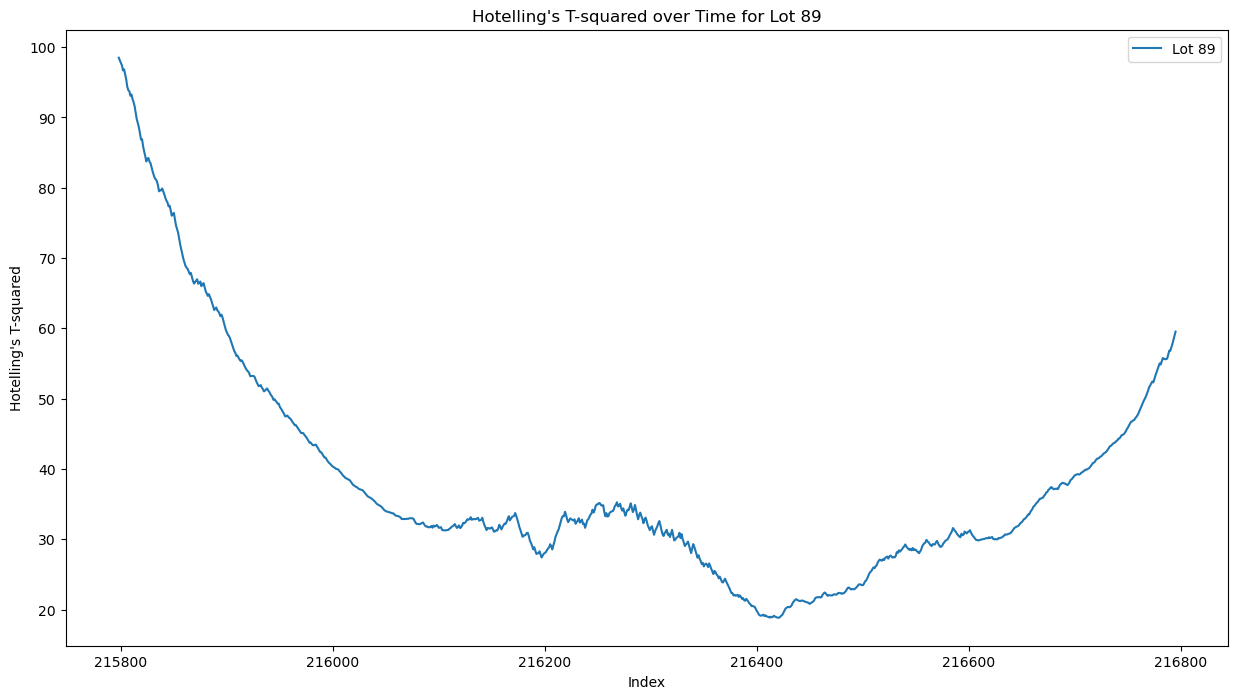

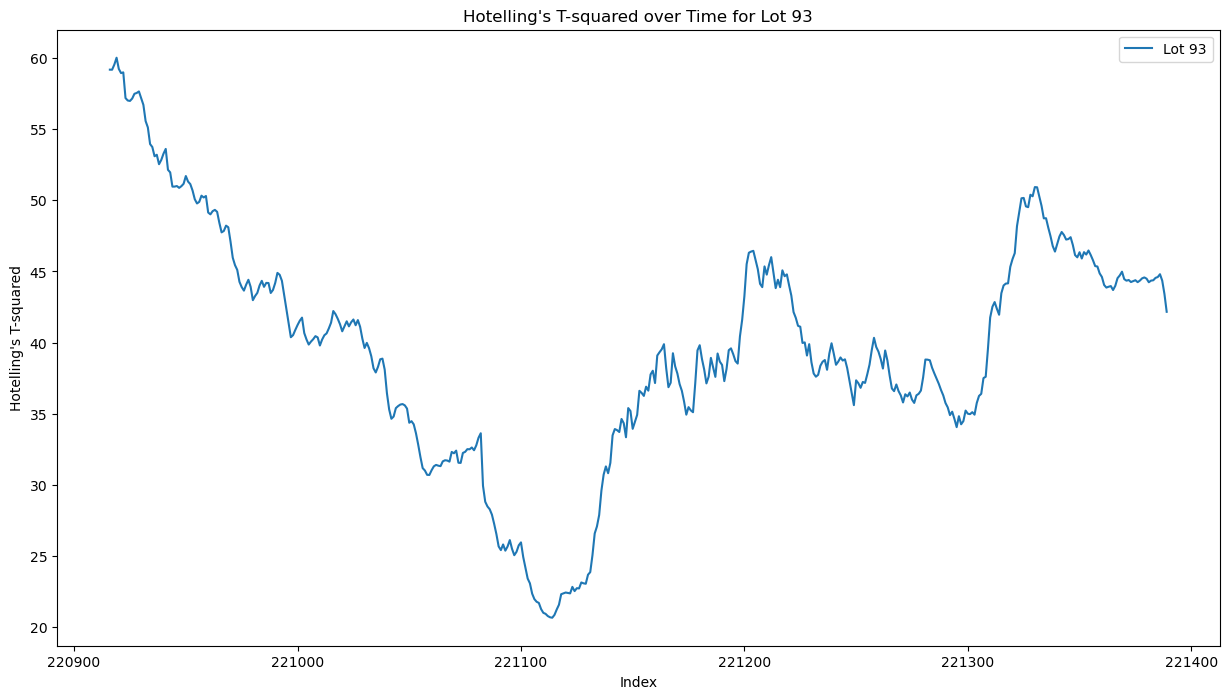

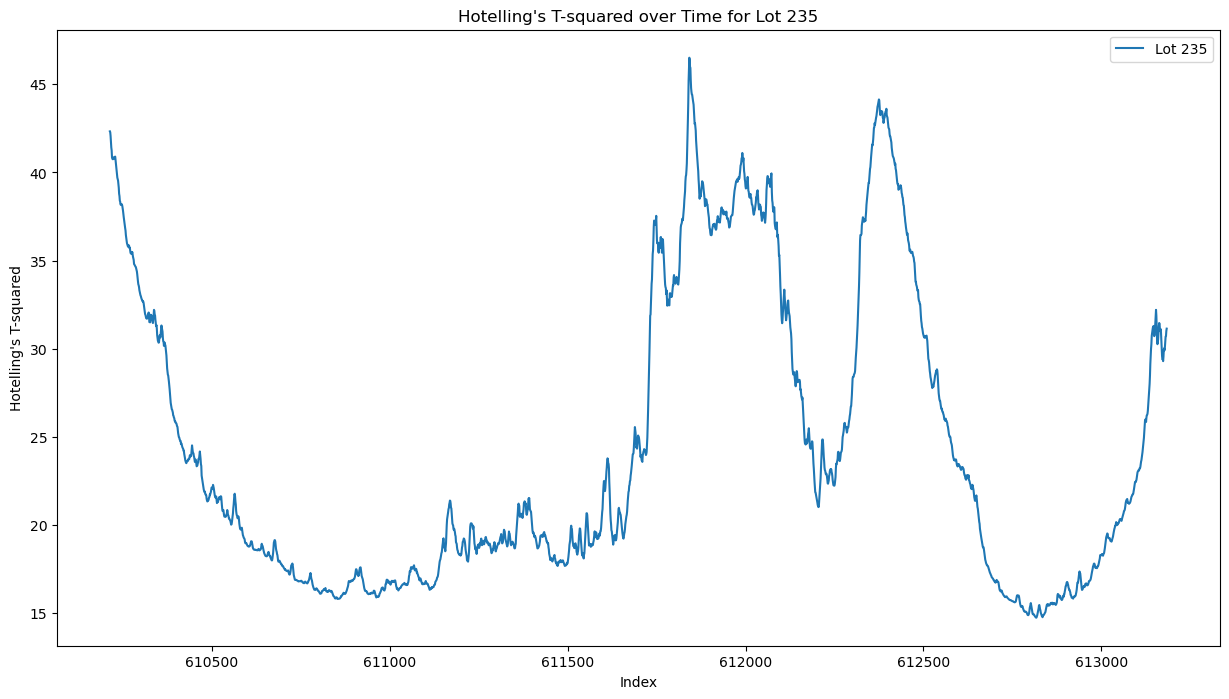

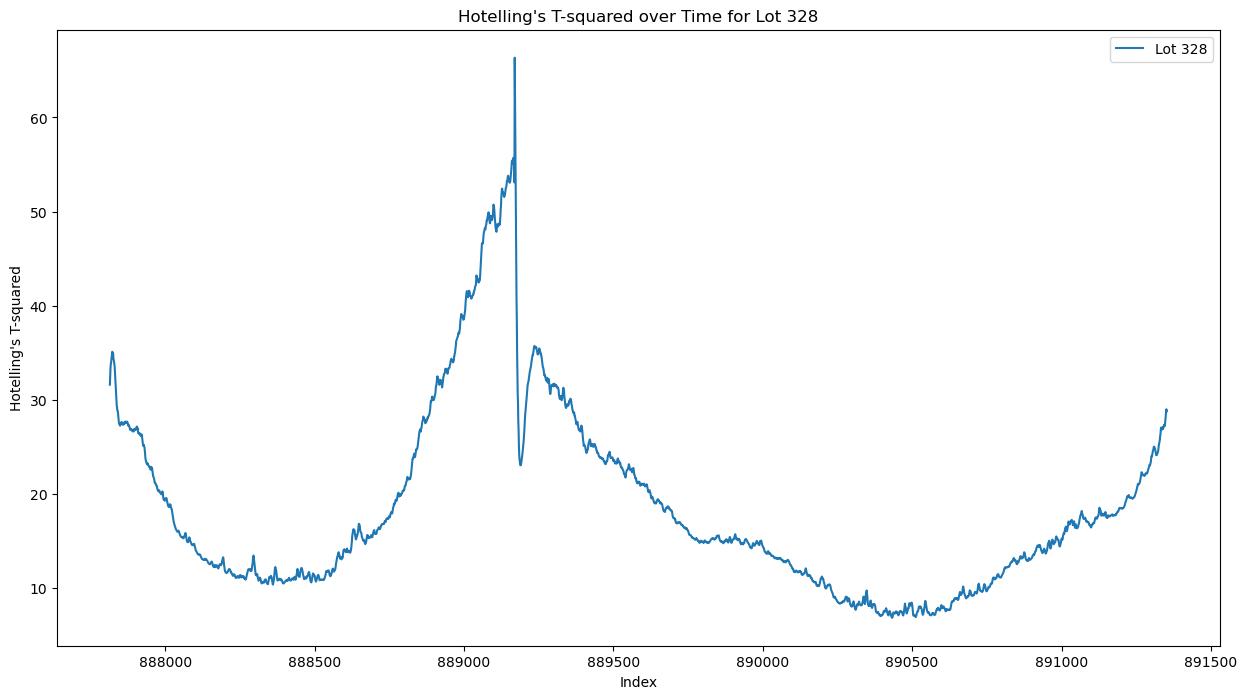

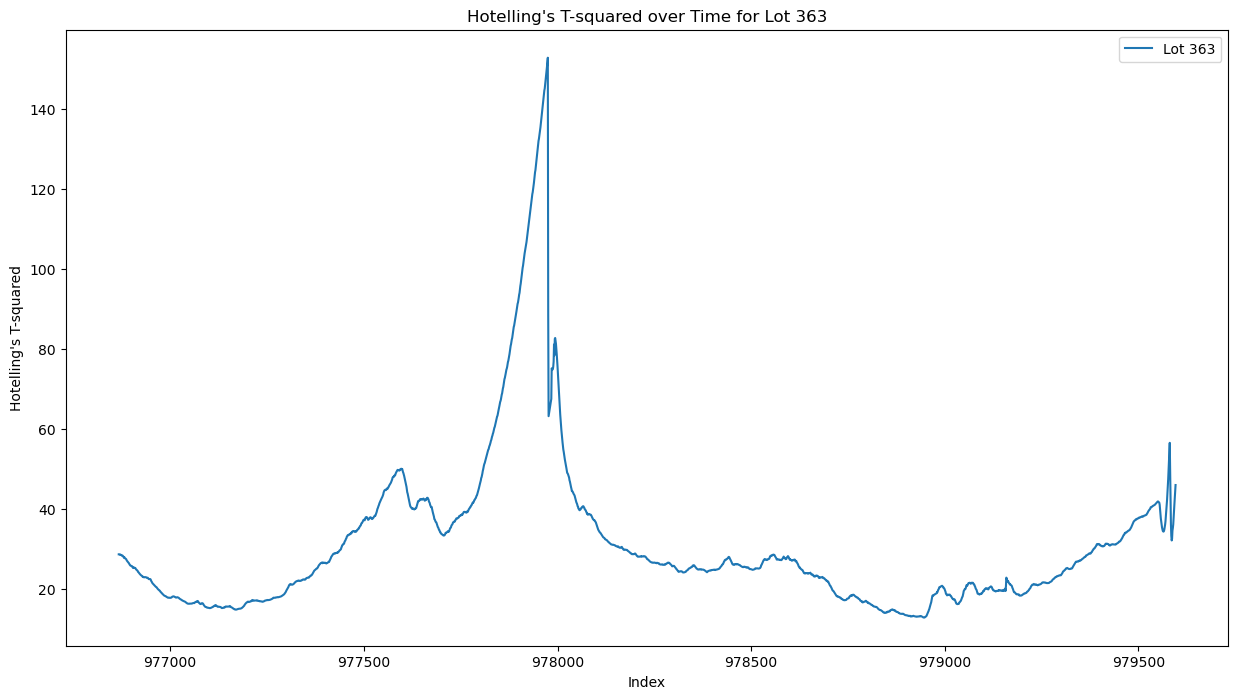

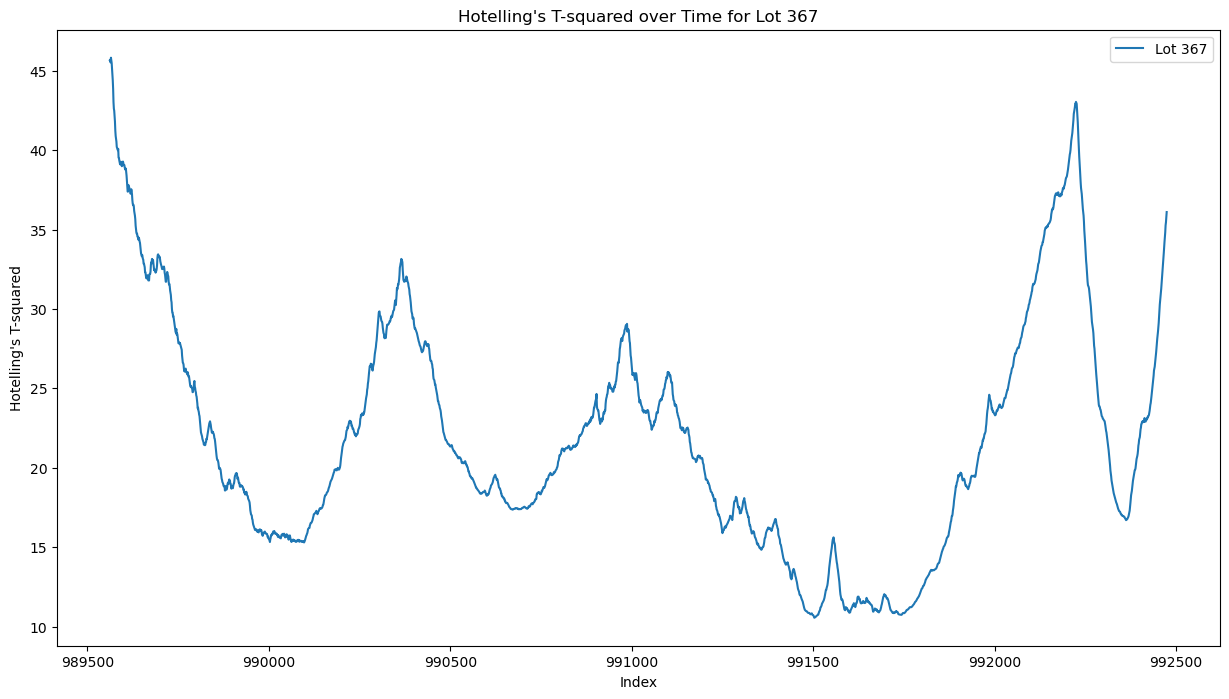

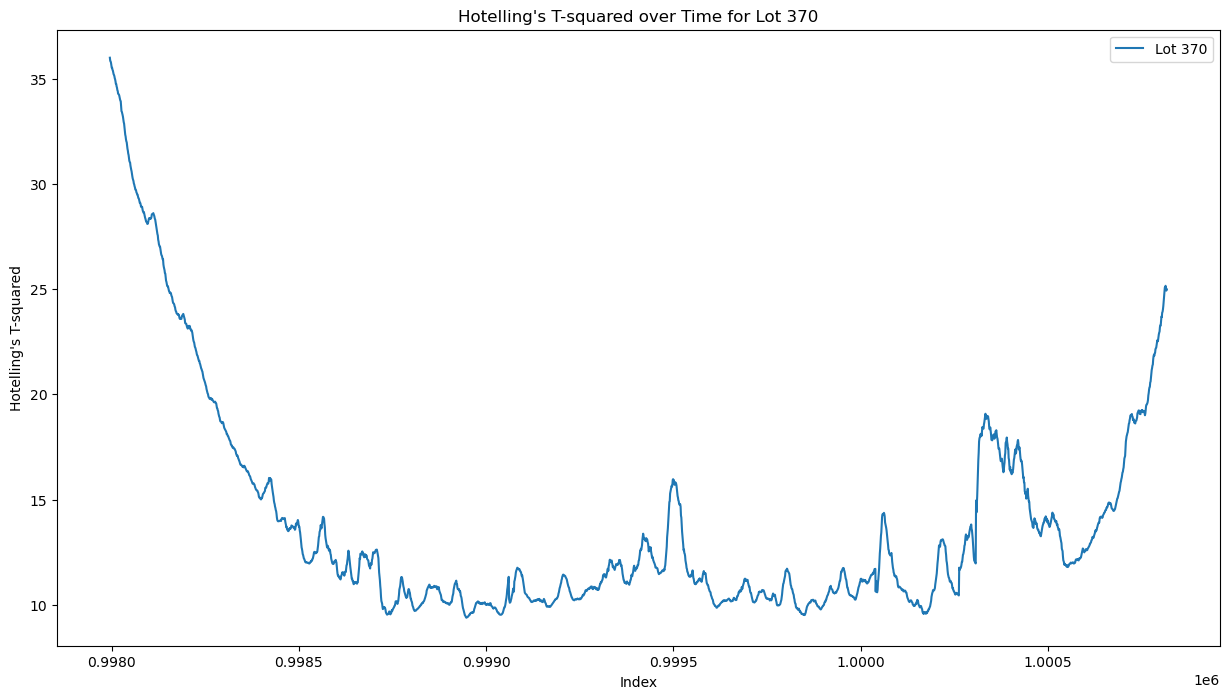

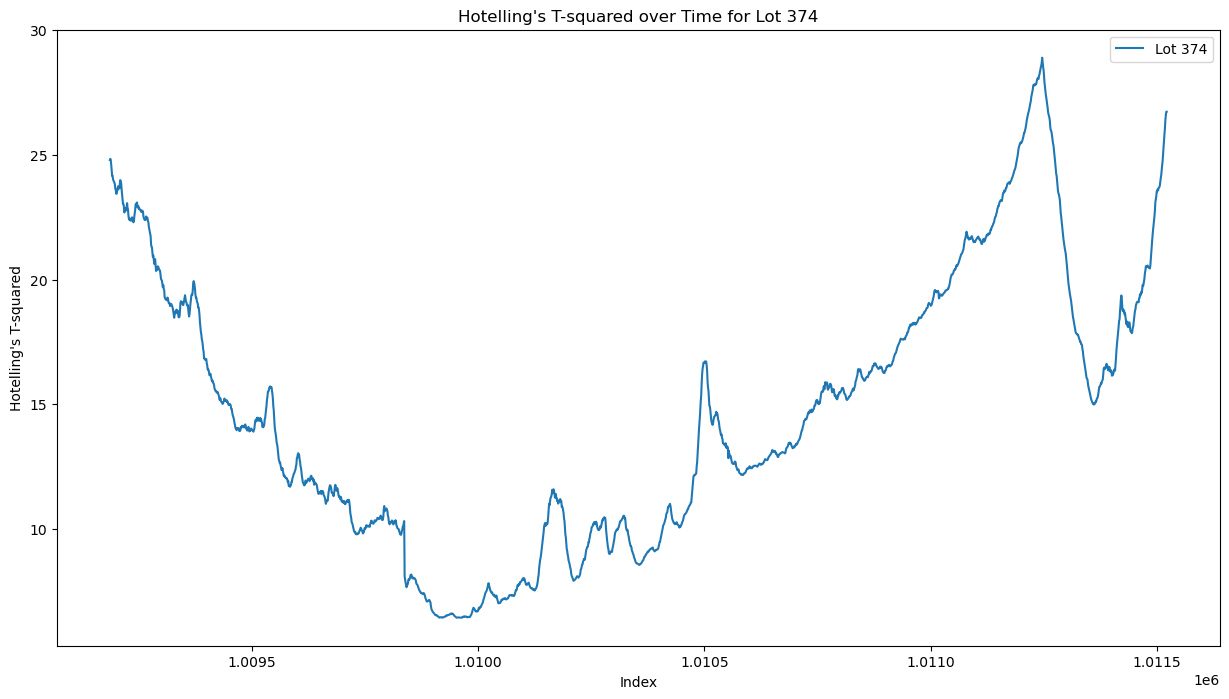

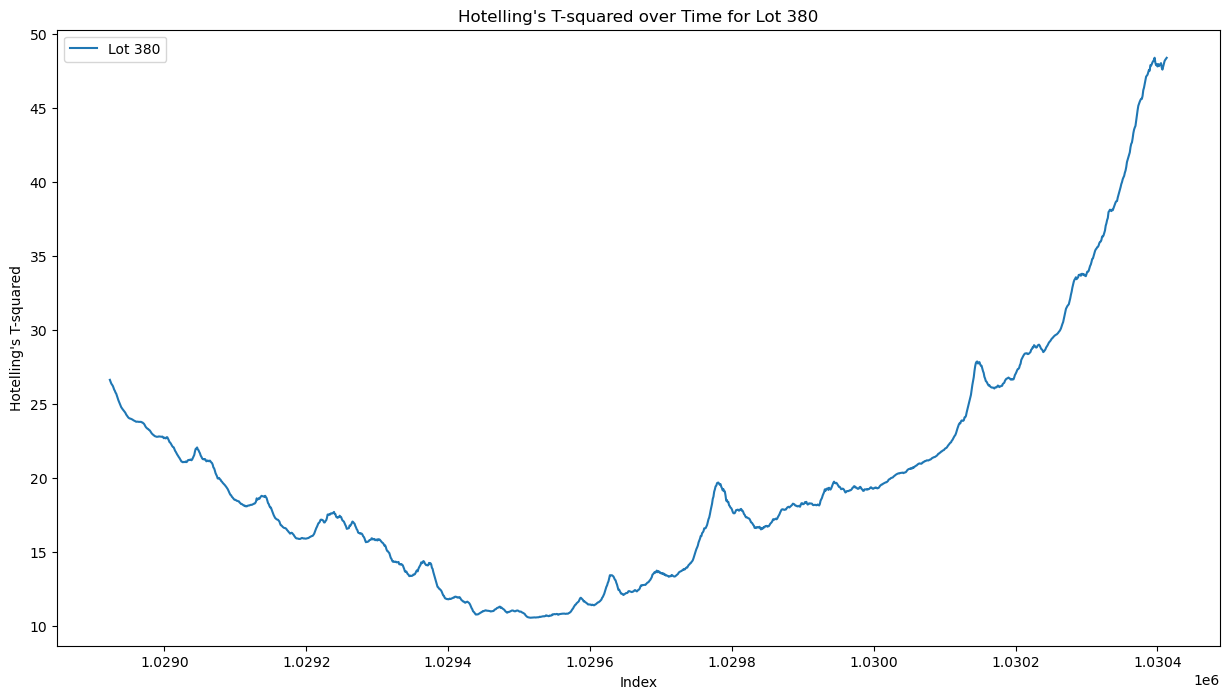

In [94]:
# Lot 번호별로 T-squared 결과값을 구분하여 시각화
unique_lots = filtered_data['Lot'].unique()

# Lot 번호가 하나인 경우
if len(unique_lots) == 1:
    lot = unique_lots[0]
    lot_indices = filtered_data[filtered_data['Lot'] == lot].index
    plt.figure(figsize=(15,8))
    plt.plot(cumulative_residuals.loc[lot_indices].index, cumulative_residuals.loc[lot_indices]['T_squared'], label=f'Lot {lot}')
    plt.xlabel('Index')
    plt.ylabel('Hotelling\'s T-squared')
    plt.title(f'Hotelling\'s T-squared over Time for Lot {lot}')
    plt.legend()
    plt.show()

# Lot 번호가 여러 개인 경우
else:
    for lot in unique_lots:
        lot_indices = filtered_data[filtered_data['Lot'] == lot].index
        plt.figure(figsize=(15,8))
        plt.plot(cumulative_residuals.loc[lot_indices].index, cumulative_residuals.loc[lot_indices]['T_squared'], label=f'Lot {lot}')
        plt.xlabel('Index')
        plt.ylabel('Hotelling\'s T-squared')
        plt.title(f'Hotelling\'s T-squared over Time for Lot {lot}')
        plt.legend()
        plt.show()

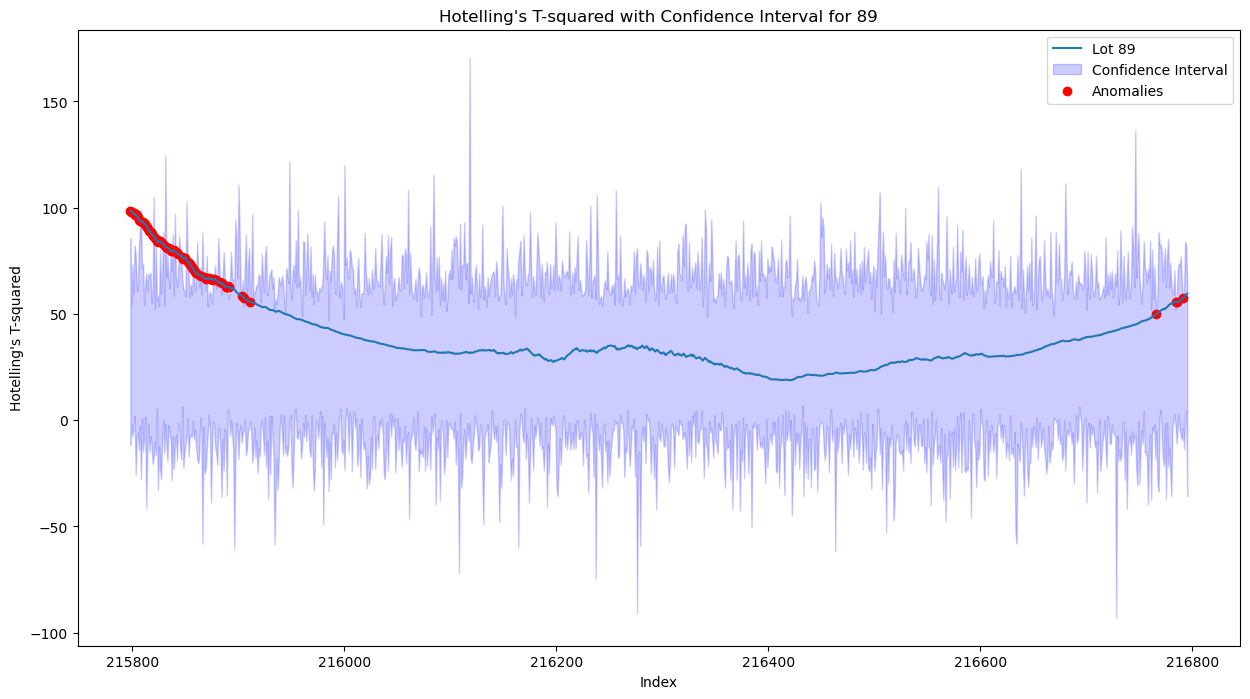

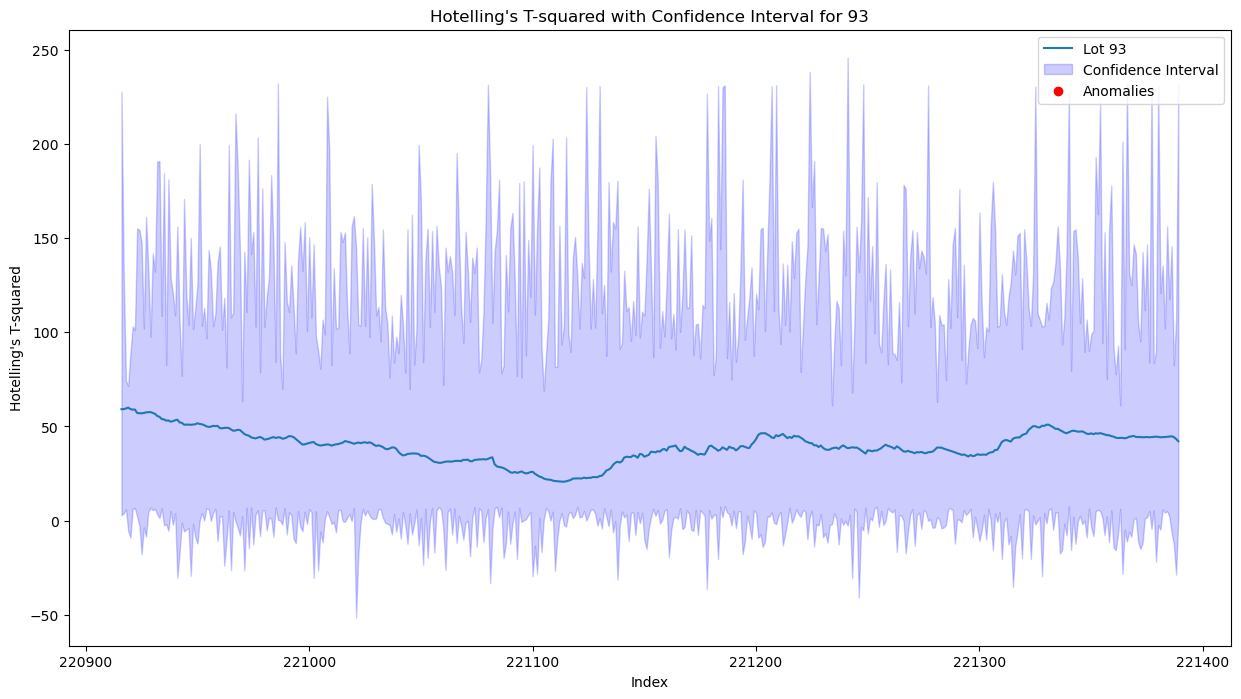

In [ ]:
def hotelling_t2(row, mean_vector, inv_cov_matrix):
    diff = row - mean_vector
    t_squared = diff @ inv_cov_matrix @ diff.T
    return t_squared

# Lot 리스트 생성
lots = filtered_data['Lot'].unique()

for lot in lots:
    lot_indices = filtered_data[filtered_data['Lot'] == lot].index
    lot_data = cumulative_residuals.loc[lot_indices]

    # Bootstrap 기반 신뢰 구간 계산
    n_iterations = 1000
    t_squared_bootstrap = np.zeros((n_iterations, len(lot_data)))

    for i in range(n_iterations):
        sample_indices = np.random.choice(lot_data.index, size=len(lot_data), replace=True)
        sample = lot_data.loc[sample_indices]
        sample_mean_vector = sample.mean(axis=0)
        sample_cov_matrix = np.cov(sample.T)
        sample_inv_cov_matrix = np.linalg.inv(sample_cov_matrix)

        t_squared_sample = sample.apply(hotelling_t2, axis=1, args=(sample_mean_vector, sample_inv_cov_matrix))
        t_squared_bootstrap[i, :] = t_squared_sample

    # 신뢰 구간 계산
    confidence_level = 0.99
    lower_bound = np.percentile(t_squared_bootstrap, (1 - confidence_level) / 2 * 100, axis=0)
    upper_bound = np.percentile(t_squared_bootstrap, (1 + confidence_level) / 2 * 100, axis=0)

    # RUL 커브 시각화
    plt.figure(figsize=(15, 8))
    plt.plot(lot_data.index, lot_data['T_squared'], label=f'Lot {lot}')
    plt.fill_between(lot_data.index, lower_bound, upper_bound, color='b', alpha=0.2, label='Confidence Interval')
    plt.xlabel('Index')
    plt.ylabel('Hotelling\'s T-squared')
    plt.title(f'Hotelling\'s T-squared with Confidence Interval for {lot}')
    plt.legend()

    # 이상 감지 시각화
    anomalies = (lot_data['T_squared'] > upper_bound) | (lot_data['T_squared'] < lower_bound)
    plt.scatter(lot_data.index[anomalies], lot_data['T_squared'][anomalies], color='r', label='Anomalies')

    plt.legend()
    plt.show()